## Plotting Time-Series Data in Real-Time 

In this example we will learn how to plot data from a Bottom Pressure and Tilt unit at the ASHES vent field in real-time.

You wil learn:

* how to find the data you are looking for
* how to use the machine to machine API to continuously request JSON data
* how to extract the relevant data on the fly and plot in real-time

Login in at https://ooinet.oceanobservatories.org/ and obtain your username and token under your profile (top right corner). Alternatively, you can use the ones provided below.

In [5]:
username = 'OOIAPI-D8S960UXPK4K03'
token = 'IXL48EQ2XY'

FYI, you can handle authentication outside the notebook by setting up a .netrc file in your home directory and loading it with your bash profile. Open your terminal
```
$ touch .netrc
$ chmod 700 .netrc
$ vim .netrc

```
Add the following your your .netrc file:

```
machine ooinet.oceanobservatories.org
login OOIAPI-TEMPD1SPK4K0X
password TEMPCXL48ET2XT
```

Use your username and token. Save the file and uncomment the following cell.

In [6]:
# import netrc
# netrc = netrc.netrc()
# remoteHostName = "ooinet.oceanobservatories.org"
# info = netrc.authenticators(remoteHostName)
# username = info[0]
# token = info[2]

In [7]:
import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import netCDF4 as nc
from IPython import display

In this example we will build real-time requests for data from the Cabled ASHES Vent Field (RS03ASHS) - Medium-Power JBox (MJ03B) - Bottom Pressure and Tilt (09-BOTPTA304) sensor. The ingredients being used to build the data_request_url can be found here: http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-09-BOTPTA304. To build an M2M request, you need the Reference Designator, Delivery Method and Data Stream Name. Note that streams containing science data products for a given instrument are designated as Science in the Type column.

![RS03ASHS-MJ03B-09-BOTPTA304](images/RS03ASHS-MJ03B-09-BOTPTA304.png)

In [8]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '09-BOTPTA304'
method = 'streamed'
stream = 'botpt_nano_sample'

The code will start by requesting the last 10 seconds of data and then make a new request every second by replacing the request url start time with the time stamp of the last data point received. No end time is specified, so everything available up until present will be returned, and the limit is set to 1000 data points for any given request. No sensor is sampling at > 100 Hz, so you are guaranteed to receive all available data in the response.

![realtime_pseudo_code](images/realtime_pseudo_code.png)

In [9]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# get the time stamp of the last 10 seconds of data
beginDT = (datetime.datetime.utcnow() - datetime.timedelta(seconds=10)).strftime("%Y-%m-%dT%H:%M:%S.000Z")

# build the url and request parameters
data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'limit':1000,   
}

Now that we have our data request url ready, let's see how long it takes for a datapoint recorded at sea to get to our notebook.

In [16]:
# get the current time
current_time = datetime.datetime.utcnow()

# launch the request
response = requests.get(data_request_url, params=params, auth=(username, token))
data = response.json()

# extract the last time stamp in the response and print
print(current_time)
print(nc.num2date(data[-1]['time'],'seconds since 1900-01-01'))

2018-06-11 18:02:05.457038
2018-06-11 18:02:05.500000


Pretty fast! Let's plot some data.

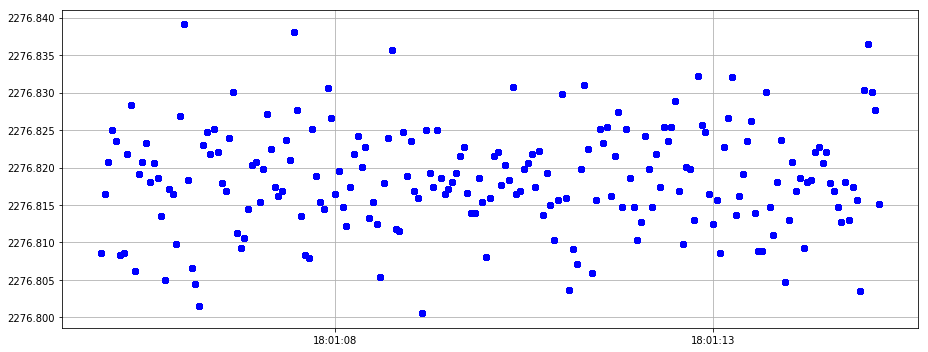

In [13]:
# set up your variable lists to extract from the json response
time_stamp = []
pressure = []

# set up the plot
plt.figure(figsize=(13,5))
plt.grid()
ax = plt.gca()

# establish a session
session = requests.session()

# enter request and plotting loop
# while True: # use for endless loop
for i in range(10):
    # send request for data
    response = session.get(data_request_url, params=params, auth=(username, token))
    data = response.json()
    
    # get last time stamp in response
    last_time = nc.num2date(data[-1]['time'],'seconds since 1900-01-01').strftime("%Y-%m-%dT%H:%M:%S.000Z")

    for i in range(len(data)):
        time_stamp.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01'))
        pressure.append(data[i]['bottom_pressure'])

    # plot the data
    plt.plot(time_stamp, pressure, marker = 'o',linestyle='None',color='Blue')

    # tighten layout and display plot
    plt.tight_layout()
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    


    # set time request time stamp = last time stamp received and plot again
    params['beginDT'] = last_time

plt.close()

Notice that points aren't just streaming onto the plot at 20 Hz, which is the sampling rate of the instrument. In this setup, your machine is drawing a new plot from scratch with each new response, which costs time and could be optimized. But that is not what is causing the couple second delay. Let's have a look at what is happening with each new request.

In [14]:
for i in range(15):  
    response = requests.get(data_request_url, params=params, auth=(username, token))
    data = response.json()
    print(nc.num2date(data[-1]['time'],'seconds since 1900-01-01'))

2018-06-11 18:01:25.350000
2018-06-11 18:01:25.350000
2018-06-11 18:01:25.350000
2018-06-11 18:01:25.350000
2018-06-11 18:01:25.350000
2018-06-11 18:01:30.300000
2018-06-11 18:01:30.300000
2018-06-11 18:01:30.300000
2018-06-11 18:01:30.300000
2018-06-11 18:01:30.300000
2018-06-11 18:01:35.400000
2018-06-11 18:01:35.400000
2018-06-11 18:01:35.400000
2018-06-11 18:01:35.400000
2018-06-11 18:01:35.400000


Notice that it takes about 5 requests for the last time stamp in the response to change. This is because new data are only released approximately five seconds when the system receives repeated requests from the same user. This is an artifical threshold that was preliminarily set. It should be possible to lower this threshold based on the demand and need for real-time data.

Below, we optimize the plotting routine to only add points if there is are new data.

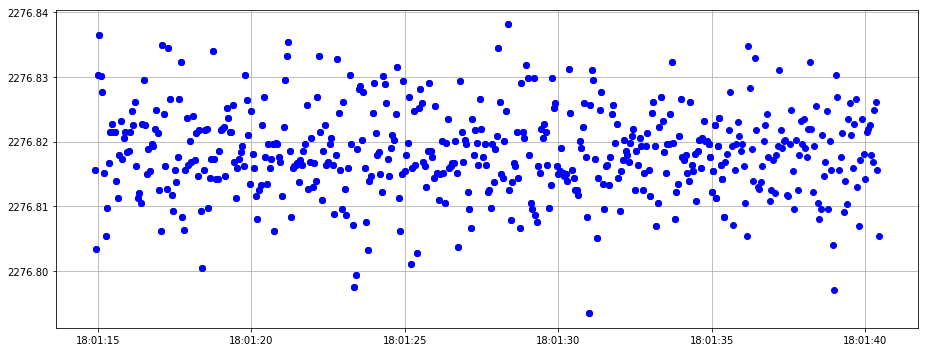

In [15]:
# set up your variable lists to extract from the json response
time_stamp = []
pressure = []

# set up the plot
plt.figure(figsize=(13,5))
plt.grid()
ax = plt.gca()

# establish a session
session = requests.session()

# enter request and plotting loop
# while True: # use for endless loop
for i in range(10):
    # send request for data
    response = session.get(data_request_url, params=params, auth=(username, token))
    data = response.json()
    
    # get last time stamp in response
    last_time = nc.num2date(data[-1]['time'],'seconds since 1900-01-01').strftime("%Y-%m-%dT%H:%M:%S.000Z")
    
    # check if new data has been received
    if params['beginDT'] == last_time:
        continue
        
    # if new data is reveived, extract and append values to list, then plot
    else:
        for i in range(len(data)):
            time_stamp.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01'))
            pressure.append(data[i]['bottom_pressure'])
         
        # plot the data
        plt.plot(time_stamp, pressure, marker = 'o',linestyle='None',color='Blue')

        # tighten layout and display plot
        plt.tight_layout()
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        # set time request time stamp = last time stamp received and plot again
        params['beginDT'] = last_time

plt.close()